In [1]:
import importlib
import ubx_parser
from matplotlib import pyplot as plt
import importer
import math
from pyproj import Proj
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
import utils
from scipy.spatial.distance import cdist


In [2]:
importlib.reload(importer)
importlib.reload(ubx_parser)
importlib.reload(utils)


filename = 'ubx_records/ground_truth_1.ubx'
ubx_1 = ubx_parser.read_ubx(filename)


filename = 'ubx_records/ground_truth_2.ubx'
ubx_2 = ubx_parser.read_ubx(filename)

Attribute error. Coordinate is ignored.


In [3]:
import importer
import importlib
importlib.reload(importer)


path = 'simra_records/'

dfs = importer.import_files(path)

#ride 1: mi9 = 14, a2 = 7 (ride Nr 6) sl_6
#ride 3: mi9 = 11, a2 = 6) sl_7

mi9_1 = importer.preprocess_basics(dfs[2], True)
a2_1 = importer.preprocess_basics(dfs[0], True)

mi9_2 = importer.preprocess_basics(dfs[1], True)
a2_2 = importer.preprocess_basics(dfs[3], True)

experiments = [(ubx_1, [mi9_1, a2_1]), (ubx_2, [mi9_2, a2_2])]

 50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

simra_records/A2_1_jacket 0
simra_records/Mi9_2_jacket 1


 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

simra_records/Mi9_1_jacket 2


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

simra_records/A2_2_jacket 3


1.0414853908992663 0.5207426954496331
1.8676004048754853 0.9338002024377426
0.7504937436641524 0.3752468718320762
0.9116694523767316 0.4558347261883658


In [4]:
## Die Frage ist hier, ob der Avg der Coords zum selben Zeitpunkt genommen werden sollten. 
## In dieser Zelle werden die Smartphone Measurements den jeweils nächstesn UBX Werten zugeordnet. An allen UBX Werten werden
## dann die Avgs gebildet. Da UBX Measurement Frequenz höher ist, gibt es sehr viele UBX Measurements mit nur einem 
## Smartphone Measurement Wert. Hier ist Avg dann ünnötig. Ist der Ansatz sinnvoll? -> JA! Siehe Thesis Algorithm 1 und Erläuternungen
from collections import defaultdict


def calc_means(data_sources, ubx_coords):
    mapped_on_ubx_dicts = []
    for ds in data_sources:
        mapped_on_ubx = calc_closest_ubx_points(ds, ubx_coords)
        mapped_on_ubx_dict = { i : mapped_on_ubx[i] for i in range(0, len(mapped_on_ubx) ) }
        
        a_s = defaultdict(list)

        for k, v in mapped_on_ubx_dict.items():
            a_s[v].append(k)

        a_s = dict(a_s)
        mapped_on_ubx_dicts.append(a_s)
    
    means = []
    for i in range(len(ubx_coords)):
        coords_p = []
        for data_source_index, coord_dict in enumerate(mapped_on_ubx_dicts):
            if i in coord_dict:
                for j in coord_dict[i]:
                    coords_p.append(data_sources[data_source_index][j])
        ## HUGE HEURISTIC!! Mean is only computed, if 2 or more cellphone coordinates are assigned to UBX coord. If <2 there is no actual mean. It would be just the distance to one ride.
        if len(coords_p) > 1:
            means.append(np.mean(coords_p, axis=0))
    return means


def calc_mean_deviation_from_ubx(data_sources, ubx):
    ubx_coords = ubx[['x', 'y']].values
    means = calc_means(data_sources, ubx_coords)
    return np.mean(calc_dists(means, ubx_coords))

In [5]:
def calc_dists(coords1, coords2):
    metric = "euclidean"
    dist = cdist(coords1, coords2, metric=metric)
    return dist.min(axis=1)
             

def calc_closest_ubx_points(coords, ubx_coords):
    metric = "euclidean"
    dist = cdist(coords, ubx_coords, metric=metric)
    return np.argmin(dist, axis=1)

In [6]:
from filterpy.kalman import predict, update

def create_F(dt):
    return np.array([[1, 1*dt, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1*dt],
                     [0, 0, 0, 1]])


In [7]:
from filterpy.common import Q_continuous_white_noise

def run_kf(data, r_factor):

    df_kf = data.copy()

    dts = (df_kf['date'] - df_kf.shift(1)['date']).dt.total_seconds().to_numpy()
    dt_mean = np.mean(np.nan_to_num(dts))
    measurements = df_kf[['x', 'y']].values

    x = np.array([measurements[0][0], 0, measurements[0][1], 0])

    F = create_F(dts[0])

    accs = df_kf['acc'].to_numpy()

    H = np.array([[1, 0, 0, 0],
                  [0, 0, 1, 0]])

    P = np.array([[accs[0]**2., 0., 0., 0.],
                [0., 1., 0., 0.], 
                [0., 0., accs[0]**2., 0.],
                [0., 0., 0., 1.]])

    R = np.eye(2) * accs[0]**2 * r_factor

    Q = Q_continuous_white_noise(dim=4, dt=dts[0])
    # Kinematic systems are continuous - their inputs and outputs can vary at any arbitrary point in time. (https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/07-Kalman-Filter-Math.ipynb)

    res = []
    f_ = 0
    t_ = len(df_kf)


    for i in range(f_, t_):
        z = measurements[i]
        if i == 0:
            dt = dts[1]
        else:
            dt = dts[i]
        F = create_F(dt)
        R = np.eye(2) * accs[i]**2 *r_factor
        Q = Q_continuous_white_noise(dim=4, dt=dt)
        x, P = predict(x, P, F, Q)    
        x, P = update(x, P, z, R, H)
        res.append(x)
    res = np.array(res)

    data['x_kf'] = res[:,0]
    data['y_kf'] = res[:,2]
    return data


In [8]:
def find_best_KF_params(experiments):
    res = []
    for exp in experiments:
        data_sources_dfs = exp[1]
        for r_factor in np.linspace(1,10,19):
            kf_filtered = []
            for ds in data_sources_dfs:
                ds = run_kf(ds, r_factor)
                kf_filtered.append(ds[['x_kf', 'y_kf']].to_numpy())

            res.append(np.array([r_factor, calc_mean_deviation_from_ubx(kf_filtered, exp[0])]))

    res = np.array(res)
    tmp = pd.DataFrame(res, columns=['fac', 'val'])
    arr = np.array(tmp.groupby('fac')['val'].mean().index.to_numpy())
    res = np.vstack([arr, tmp.groupby('fac')['val'].mean().to_numpy()]).T
    return res[np.argmin(res[:,1])][0], res

In [9]:
kf_params, kf_params_info = find_best_KF_params(experiments)
kf_params_info

array([[ 1.        ,  8.90634951],
       [ 1.5       ,  9.04883007],
       [ 2.        ,  9.12866765],
       [ 2.5       ,  9.05258329],
       [ 3.        ,  8.99823791],
       [ 3.5       ,  9.14169968],
       [ 4.        ,  9.20529907],
       [ 4.5       ,  9.23152542],
       [ 5.        ,  9.3263578 ],
       [ 5.5       ,  9.50779998],
       [ 6.        ,  9.52026137],
       [ 6.5       ,  9.55998768],
       [ 7.        ,  9.52199896],
       [ 7.5       ,  9.51548551],
       [ 8.        ,  9.52909991],
       [ 8.5       ,  9.43325258],
       [ 9.        ,  9.41910591],
       [ 9.5       ,  9.2829928 ],
       [10.        ,  9.28421713]])

In [10]:
def find_best_MA_params(experiments):
    res = []
    for exp in experiments:
        
        data_sources = []
        for df in exp[1]:
            data_sources.append(df[['x', 'y']].to_numpy())
        
        for w in np.linspace(1,40,40, dtype = int):  
            ma_filtered = []
            for ds in data_sources:
                df = pd.DataFrame(ds, columns=['x', 'y'])
                df['x_ma'] = df.x.rolling(w, center=True, min_periods = 1).mean()
                df['y_ma'] = df.y.rolling(w, center=True, min_periods = 1).mean()
                ma_filtered.append(df[['x_ma', 'y_ma']].to_numpy())

            res.append(np.array([w, calc_mean_deviation_from_ubx(ma_filtered, exp[0])]))

    res_raw = np.array(res)
    tmp = pd.DataFrame(res_raw, columns=['w','val'])

    arr = np.array(tmp.groupby('w')['val'].mean().index.to_numpy())
    res = np.vstack([arr, tmp.groupby('w')['val'].mean().to_numpy()]).T
    return res[np.argmin(res[:,1])][0], res

In [11]:
ma_params, ma_params_info = find_best_MA_params(experiments)
ma_params

5.0

In [12]:
win_type = 'gaussian'

def find_best_kernel_params(experiments):

    res = []
    for exp in experiments: 
        data_sources = []
        for df in exp[1]:
            data_sources.append(df[['x', 'y']].to_numpy())
            
        for std in np.linspace(1, 4, 25):
            for w in np.linspace(1, 40, 40).astype('int'):
                if w % 2 != 0:
                    continue
                k_filtered = []
                for ds in data_sources:
                    df = pd.DataFrame(ds, columns=['x', 'y'])
                    df['x_k'] = df.x.rolling(window=w, win_type=win_type, center=True, min_periods = 1).mean(std=std)
                    df['y_k'] = df.y.rolling(window=w, win_type=win_type, center=True, min_periods = 1).mean(std=std)
                    k_filtered.append(df[['x_k', 'y_k']].to_numpy())

                res.append(np.array([w, std, calc_mean_deviation_from_ubx(k_filtered, exp[0])]))

    res_raw = np.array(res)                                    
    tmp = pd.DataFrame(res_raw, columns=['w', 'std', 'val'])

    arr = np.array(tmp.groupby(['w', 'std'])['val'].mean().index.to_numpy())
    res = np.vstack([arr, tmp.groupby(['w', 'std'])['val'].mean().to_numpy()]).T
    return res[np.argmin(res[:,1])][0], res

In [13]:
kernel_params, k_params_info = find_best_kernel_params(experiments)
kernel_params

(22.0, 2.5)

mean coord error: 		 9.627541157858186
mean coord error MA: 		 9.312857277881626 	 ( -0.03268579950133044 )
mean coord error Kernel: 	 9.33846554275606 	 ( -0.03002590280968853 )
mean coord error KF: 		 9.887947524525924 	 ( 0.027048065793537468 )
mean coord error: 		 10.787995092734228
mean coord error MA: 		 10.265051762401942 	 ( -0.04847456138393047 )
mean coord error Kernel: 	 10.017564196249321 	 ( -0.07141557720987435 )
mean coord error KF: 		 11.201931348744527 	 ( 0.03837008197093894 )
mean coord error: 		 5.904446836830211
mean coord error MA: 		 5.76652765834218 	 ( -0.023358526598585394 )
mean coord error Kernel: 	 5.887098257162448 	 ( -0.002938222689981451 )
mean coord error KF: 		 6.067192249725021 	 ( 0.027563193876122494 )
mean coord error: 		 10.46667152324738
mean coord error MA: 		 10.427541862588193 	 ( -0.003738500876068973 )
mean coord error Kernel: 	 10.539439583995238 	 ( 0.006952359265907315 )
mean coord error KF: 		 10.546371727389747 	 ( 0.00761466565233726 

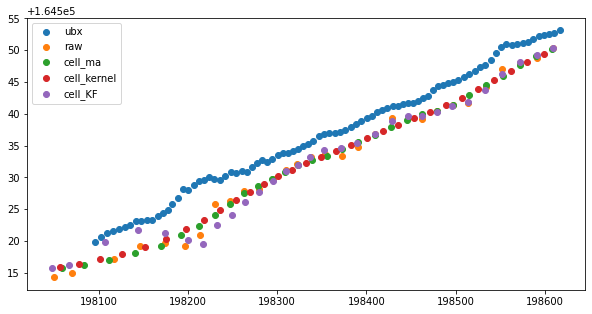

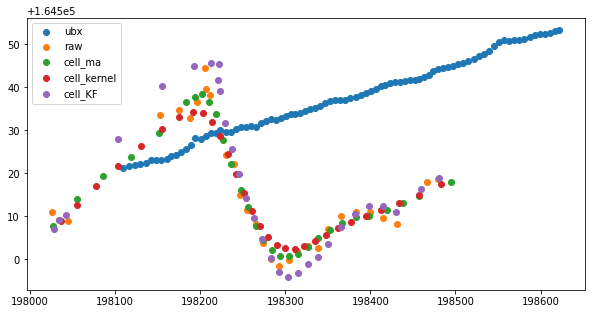

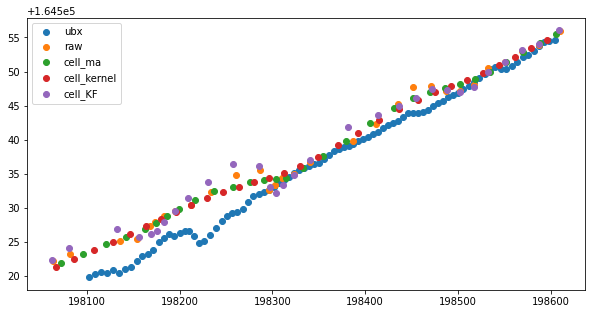

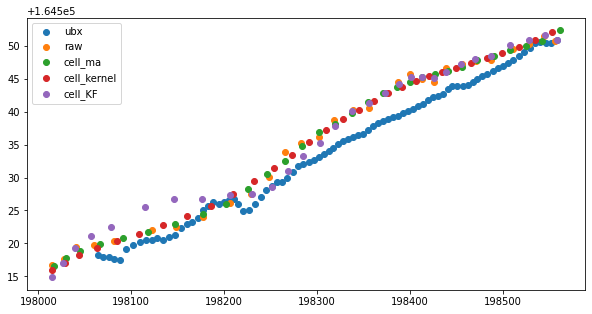

In [14]:
raw_datas = []
kf_datas = []
ma_datas = []
k_datas = []

for exp in experiments:
    
    raw_data = []
    kf_data = []
    ma_data = []
    k_data = []

    ubx = exp[0]
    ubx_coords = ubx[['x', 'y']].to_numpy()
    
    for ds in exp[1]:

        coords = ds[['x', 'y']].to_numpy()
        raw_data.append(coords)
        
        comp = pd.DataFrame()
        comp['error'] = calc_dists(coords, ubx_coords)

        kf_tmp = run_kf(ds, kf_params)
        kf_coords = kf_tmp[['x_kf', 'y_kf']].values
        comp['error_KF'] = calc_dists(kf_coords, ubx_coords)
        kf_data.append(kf_coords)

        ma_w = int(ma_params)
        ma_tmp = pd.DataFrame(coords, columns=['x', 'y'])
        ma_tmp['x_ma'] = ma_tmp.x.rolling(ma_w, center=True, min_periods=1).mean()
        ma_tmp['y_ma'] = ma_tmp.y.rolling(ma_w, center=True, min_periods=1).mean()
        ma_coords = ma_tmp[['x_ma', 'y_ma']].values
        comp['error_MA'] = calc_dists(ma_coords, ubx_coords)
        ma_data.append(ma_coords)


        kernel_w = int(kernel_params[0])
        kernel_std = kernel_params[1]
        win_type = 'gaussian'
        k_tmp = pd.DataFrame(coords, columns=['x', 'y'])
        k_tmp['x_k'] = k_tmp.x.rolling(window=kernel_w, win_type=win_type, center=True, min_periods=1).mean(std=kernel_std)
        k_tmp['y_k'] = k_tmp.y.rolling(window=kernel_w, win_type=win_type, center=True, min_periods=1).mean(std=kernel_std)
        k_coords = k_tmp[['x_k', 'y_k']].values
        comp['error_K'] = calc_dists(k_coords, ubx_coords)
        k_data.append(k_coords)


        plt.figure(figsize=(10,5))

        f = 150
        t = 180

        plt.scatter(ubx[ubx.date.between(ds[f:t].iloc[0].date, ds[f:t].iloc[-1].date)].x, ubx[ubx.date.between(ds[f:t].iloc[0].date, ds[f:t].iloc[-1].date)].y, label='ubx')
        plt.scatter(coords[:,0][f:t], coords[:,1][f:t], label='raw')
        plt.scatter(ma_tmp.x_ma[f:t], ma_tmp.y_ma[f:t], label='cell_ma')
        plt.scatter(k_tmp.x_k[f:t], k_tmp.y_k[f:t], label='cell_kernel')
        plt.scatter(kf_tmp.x_kf[f:t], kf_tmp.y_kf[f:t], label='cell_KF')


        plt.legend()

        #plt.plot(comp_p10.date, comp_p10.error)

        raw_error = comp['error'].mean()
        print('mean coord error: \t\t', raw_error)
        print('mean coord error MA: \t\t', comp['error_MA'].mean(), '\t (', (comp['error_MA'].mean()/raw_error) - 1, ')')
        print('mean coord error Kernel: \t', comp['error_K'].mean(), '\t (', (comp['error_K'].mean()/raw_error) - 1, ')')
        print('mean coord error KF: \t\t', comp['error_KF'].mean(), '\t (', (comp['error_KF'].mean()/raw_error) - 1, ')')
        #print('P10 mean coord error: \t', comp_p10.error.mean())
        
    raw_datas.append(raw_data)
    kf_datas.append(kf_data)
    ma_datas.append(ma_data)
    k_datas.append(k_data)
        

In [15]:
raw_errors = []
ma_errors = []
k_errors = []
kf_errors = []

for i, exp in enumerate(experiments):   
    raw_errors.append(calc_mean_deviation_from_ubx([exp[1][0][['x', 'y']].to_numpy(), exp[1][1][['x', 'y']].to_numpy()], exp[0]))
    kf_errors.append(calc_mean_deviation_from_ubx(kf_datas[i], exp[0]))
    ma_errors.append(calc_mean_deviation_from_ubx(ma_datas[i], exp[0]))
    k_errors.append(calc_mean_deviation_from_ubx(k_datas[i], exp[0]))

print('Avg coords mean coord error: \t\t', np.mean(raw_errors))
print('Avg coords mean coord error MA: \t', np.mean(ma_errors), '\t (', (np.mean(ma_errors)/np.mean(raw_errors)) - 1,')')
print('Avg coords mean coord error Kernel: \t', np.mean(k_errors), '\t (', (np.mean(k_errors)/np.mean(raw_errors)) - 1, ')')
print('Avg coords mean coord error KF: \t', np.mean(kf_errors), '\t (', (np.mean(kf_errors)/np.mean(raw_errors)) - 1, ')')


Avg coords mean coord error: 		 9.108923737994118
Avg coords mean coord error MA: 	 8.486030166346788 	 ( -0.0683827847903904 )
Avg coords mean coord error Kernel: 	 8.365679601064206 	 ( -0.08159516517080667 )
Avg coords mean coord error KF: 	 8.90634951394458 	 ( -0.022239095405375275 )


In [16]:
raw_means = np.array(calc_means(raw_data, ubx_coords))
kf_means = np.array(calc_means(kf_data, ubx_coords))
ma_means = np.array(calc_means(ma_data, ubx_coords))
k_means = np.array(calc_means(k_data, ubx_coords))


def inverse_project(coords):
    proj = Proj('epsg:5243')
    return proj(coords[0], coords[1], inverse=True)

proj_ubx = np.apply_along_axis(inverse_project, 1, ubx_coords)
proj_raw_means = np.apply_along_axis(inverse_project, 1, raw_means)
proj_kf_means = np.apply_along_axis(inverse_project, 1, kf_means)
proj_ma_means = np.apply_along_axis(inverse_project, 1, ma_means)
proj_k_means = np.apply_along_axis(inverse_project, 1, k_means)


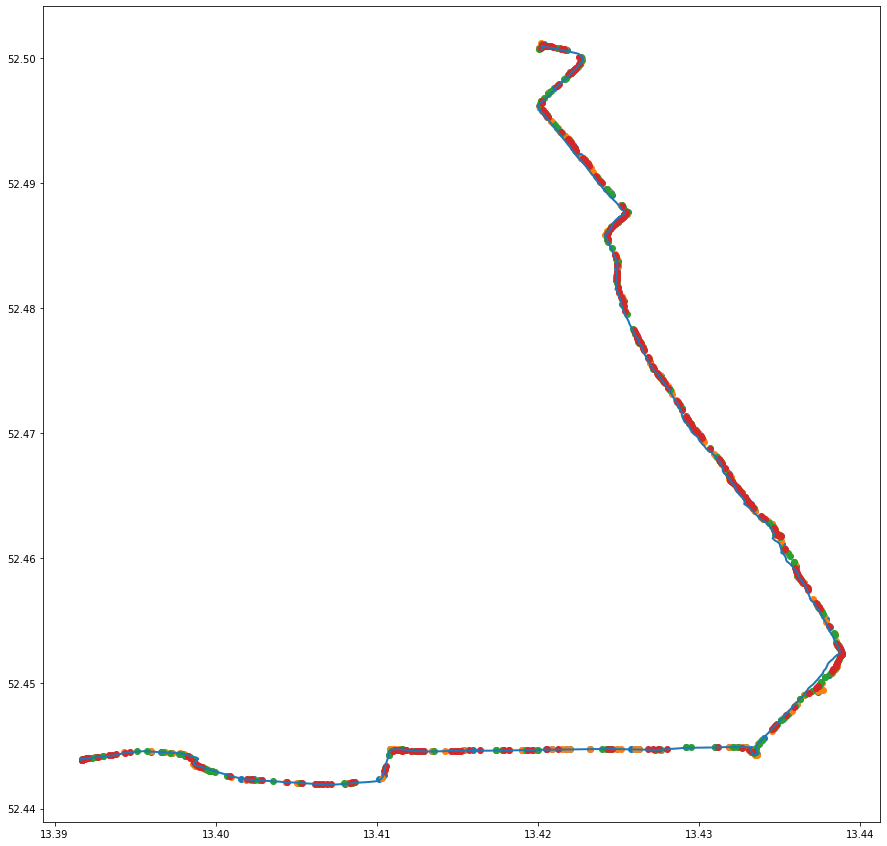

In [17]:
map_data = plt.figure(figsize=(15,15))
plt.plot(proj_ubx[:,0], proj_ubx[:,1], linewidth=2, label='raw means')
plt.scatter(proj_raw_means[:,0], proj_raw_means[:,1], label='raw means')
plt.scatter(proj_kf_means[:,0], proj_kf_means[:,1], label='kf means')
plt.scatter(proj_ma_means[:,0], proj_ma_means[:,1], label='ma means')
plt.scatter(proj_k_means[:,0], proj_k_means[:,1], label='k means')


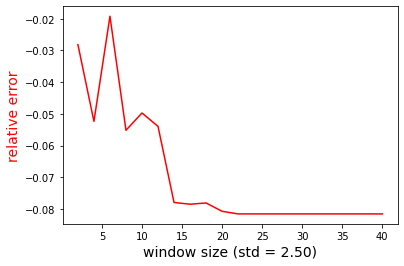

Text(0.5, 0, 'kernel std (window size = 22)')

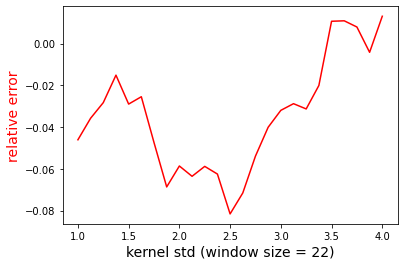

In [19]:
### Evaluation of Kernel Params

infos = []
for info in k_params_info:
    infos.append([info[0][0], info[0][1], info[1]])

df = pd.DataFrame(infos, columns=['w', 'std', 'val'])
df = df[df['std'] == kernel_params[1]]


plt.plot(df.w, (df.val/np.mean(raw_errors)) - 1, color='red')
plt.ylabel('relative error',color='red',fontsize=14)
plt.xlabel('window size (std = %.2f)'%kernel_params[1],fontsize=14)
plt.show()

df = pd.DataFrame(infos, columns=['w', 'std', 'val'])
df = df[df['w'] == kernel_params[0]]
plt.plot(df['std'], (df.val/np.mean(raw_errors)) - 1, color='red')
plt.ylabel('relative error',color='red',fontsize=14)
plt.xlabel('kernel std (window size = %i)'%kernel_params[0],fontsize=14)

Text(0.5, 0, 'window size')

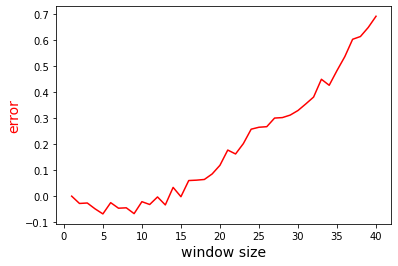

In [20]:
## Evaluation of MA Params

df = pd.DataFrame(ma_params_info, columns=['w', 'val'])

plt.plot(df.w, (df.val/np.mean(raw_errors)) - 1, color='red')

plt.ylabel('error',color='red',fontsize=14)
plt.xlabel('window size',fontsize=14)


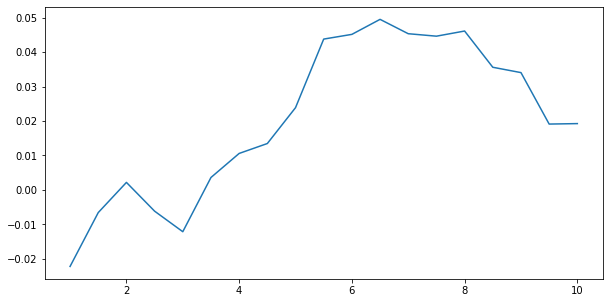

In [22]:
# Evaluation of KF-Params

plt.figure(figsize=(10,5))
plt.plot(kf_params_info[:,0], (kf_params_info[:,1]/np.mean(raw_errors)) - 1)